# Hyperparameter Tuning with MLJFlux

In this workflow example we learn how to tune different hyperparameters of MLJFlux models with emphasis on training hyperparameters.

In [1]:
using Pkg
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/docs/src/workflow examples/Hyperparameter Tuning`


**Julia version** is assumed to be 1.10.*

### Basic Imports

In [2]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
import RDatasets        # Dataset source
using Plots             # To plot tuning results
import Optimisers       # native Flux.jl optimisers no longer supported

### Loading and Splitting the Data

In [3]:
iris = RDatasets.dataset("datasets", "iris");
y, X = unpack(iris, ==(:Species), colname -> true, rng=123);
X = Float32.(X);      # To be compatible with type of network network parameters

### Instantiating the model

Now let's construct our model. This follows a similar setup the one followed in the
[Quick Start](../../index.md#Quick-Start).

In [4]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux
clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Optimisers.Adam(0.01),
    batch_size=8,
    epochs=10,
    rng=42,
)

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.01, (0.9, 0.999), 1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

### Hyperparameter Tuning Example

Let's tune the batch size and the learning rate. We will use grid search and 5-fold
cross-validation.

We start by defining the hyperparameter ranges

In [5]:
r1 = range(clf, :batch_size, lower=1, upper=64)
etas = [10^x for x in range(-4, stop=0, length=4)]
optimisers = [Optimisers.Adam(eta) for eta in etas]
r2 = range(clf, :optimiser, values=optimisers)

NominalRange(optimiser = Adam(0.0001, (0.9, 0.999), 1.0e-8), Adam(0.00215443, (0.9, 0.999), 1.0e-8), Adam(0.0464159, (0.9, 0.999), 1.0e-8), ...)

Then passing the ranges along with the model and other arguments to the `TunedModel`
constructor.

In [6]:
tuned_model = TunedModel(
    model=clf,
    tuning=Grid(goal=25),
    resampling=CV(nfolds=5, rng=42),
    range=[r1, r2],
    measure=cross_entropy,
);

Then wrapping our tuned model in a machine and fitting it.

In [7]:
mach = machine(tuned_model, X, y);
fit!(mach, verbosity=0);

Let's check out the best performing model:

In [8]:
fitted_params(mach).best_model

NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.0464159, (0.9, 0.999), 1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 1, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

### Learning Curves

With learning curves, it's possible to center our focus on the effects of a single
hyperparameter of the model

First define the range and wrap it in a learning curve

In [9]:
r = range(clf, :epochs, lower=1, upper=200, scale=:log10)
curve = learning_curve(
    clf,
    X,
    y,
    range=r,
    resampling=CV(nfolds=4, rng=42),
    measure=cross_entropy,
)

[ Info: Training machine(ProbabilisticTunedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: Attempting to evaluate 25 models.
Evaluating over 25 metamodels: 100%[=========================] Time: 0:00:05


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 9, 11, 13  …  39, 46, 56, 67, 80, 96, 116, 139, 167, 200],
 measurements = [0.9231712033780419, 0.7672938542047157, 0.6736075721456418, 0.6064130950372606, 0.5595521804926612, 0.5270759259385482, 0.5048969423979114, 0.47993815474701584, 0.46130985568830307, 0.4449225600160762  …  0.1621185148276446, 0.12283639917434747, 0.09543014842693512, 0.07850181447968614, 0.06950203807005066, 0.063248279208185, 0.060053521895940286, 0.05921442672620914, 0.05921052970422136, 0.060379476300399186],)

Then plot the curve

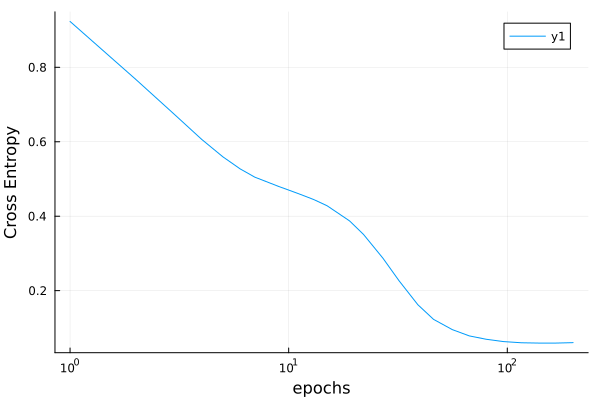

In [10]:
plot(
    curve.parameter_values,
    curve.measurements,
    xlab=curve.parameter_name,
    xscale=curve.parameter_scale,
    ylab = "Cross Entropy",
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*